In [1]:
!git clone https://github.com/PiotrJZielinski/ml-throwdown-datasets

fatal: destination path 'ml-throwdown-datasets' already exists and is not an empty directory.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# losowe dane dla dwóch klas, przy przesunięciu środka rozkładu
train_data = np.vstack((np.random.normal(size=(100, 2)),
                        np.random.normal(size=(100, 2), loc=2)))
train_labels = np.hstack((np.zeros(100), np.ones(100)))


Kolejny raz sprawdzimy, w jaki sposób klasyfikator dzieli naszą dwuwymiarową przestrzeń.

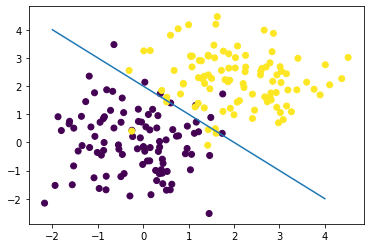

In [2]:
fig, ax = plt.subplots()
ax.scatter(train_data[:, 0], train_data[:, 1], c=train_labels)
ax.plot(range(-2, 5), range(4, -3, -1))
plt.show()

In [3]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=4)
knn.fit(train_data, train_labels)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                     weights='uniform')

In [4]:
def get_grid(data):
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
    return np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))


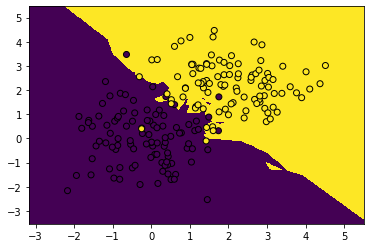

In [5]:
xs, ys = get_grid(train_data)

predicted = knn.predict(
    np.column_stack((xs.flatten(),
                     ys.flatten()))).reshape(xs.shape)

fig, ax = plt.subplots()
ax.pcolormesh(xs, ys, predicted)
ax.scatter(train_data[:, 0], train_data[:, 1], c=train_labels, edgecolors='k')
plt.show()

Widać tutaj dziwne szumy - wynikają one wprost z zasady działania algorytmu.

Teraz porównamy dla problemu liniowo nie separowalnego.

In [6]:
from sklearn.datasets.samples_generator import make_moons
X, y = make_moons(n_samples=100, noise=0.05)

In [7]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier()
model.fit(X, y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

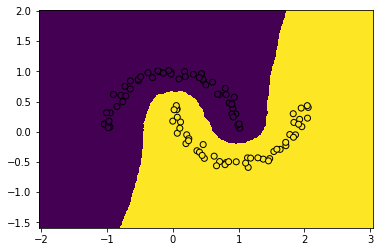

In [8]:
import matplotlib.pyplot as plt

xs, ys = get_grid(X)

predicted = model.predict(
    np.column_stack((xs.flatten(),
                     ys.flatten()))).reshape(xs.shape)

fig, ax = plt.subplots()
ax.pcolormesh(xs, ys, predicted)
ax.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k')
plt.show()

Klasyfikator poradził sobie zaskakująco dobrze!

Wczytamy teraz dane rzeczywiste i spróbujemy ocenić poprawność działania modelu - wykorzystamy zbiór Wine

In [9]:
import pandas as pd

def load_dataset(filename, class_column, index_col=None):
    dataset = pd.read_csv(f'ml-throwdown-datasets/{filename}.csv', index_col=index_col)
    dataset['class'] = dataset[class_column].astype('category').cat.codes
    classes = dataset.pop(class_column).unique()
    return dataset, classes

def prepare_dataset(dataset_name):
    params = {'iris': {'class_column': 'species', 'index_col': None},
              'wine': {'class_column': 'Class', 'index_col': None},
              'glass': {'class_column': 'Type', 'index_col': 'ID'},
              'diabetes': {'class_column': 'Class', 'index_col': None}}
    dataset, classes = load_dataset(dataset_name,
                                    **params[dataset_name])
    y = dataset.pop('class')
    X = dataset
    return X, y, classes

In [10]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# average:
#   None - wyniki dla każdej klasy osobno
#   'binary' - dla wybranej w `pos_label` etykiety
#   'micro' - dla całkowitej liczby TP, FN, FP
#   'macro' - nieważona średnia dla każdej klasy
#   'weighted' - ważona średnia dla każdej klasy

def calculate_metrics(target, prediction, average='macro'):
    accuracy = accuracy_score(target, prediction)
    precision = precision_score(target, prediction, average=average)
    recall = recall_score(target, prediction, average=average)
    f1 = f1_score(target, prediction, average=average)
    mislabeled = (target != prediction).sum()
    total = len(target)
    return accuracy, precision, recall, f1, mislabeled, total

def print_results(metrics, classifier_id='classifier'):
    print(f'Results for {classifier_id}')
    print('----')
    print(f'  Accuracy:  {metrics[0]}')
    print(f'  Precision: {metrics[1]}')
    print(f'  Recall:    {metrics[2]}')
    print(f'  F1 score:  {metrics[3]}')
    print(f'  Mislabeled {metrics[4]} out of {metrics[5]}')
    print('\n')

In [11]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_cm(conf_mtx, classes=None):
    df = pd.DataFrame(conf_mtx, index=classes, columns=classes)
    g = sns.heatmap(df, annot=True, cmap='Blues')
    g.set_ylabel('Truth')
    g.set_xlabel('Prediction')
    return g

In [12]:
def cross_validate(classifier, kfold, X, y, params=None):
    if params is None:
        params = {}
    predicted = []
    target = []
    for train_index, test_index in kfold.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        clf = classifier(**params).fit(X_train, y_train)
        predicted = np.concatenate((predicted,
                                    clf.predict(X_test)))
        target = np.concatenate((target,
                                 y_test))
    metrics = calculate_metrics(target, predicted)
    cm = confusion_matrix(target, predicted)
    return metrics, cm

In [32]:
X, y, classes = prepare_dataset('wine')

Results for KNN-no-preprocessing
----
  Accuracy:  0.6966292134831461
  Precision: 0.6790255073837163
  Recall:    0.6867589719105593
  F1 score:  0.6809207928610913
  Mislabeled 54 out of 178




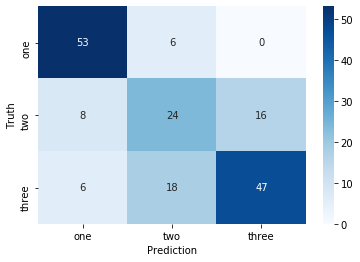

In [22]:
from sklearn.model_selection import StratifiedKFold

metrics, cm = cross_validate(KNeighborsClassifier, StratifiedKFold(9), X, y)

print_results(metrics, 'KNN-no-preprocessing')
plot_cm(cm, classes)

Jest nienajlepiej! dlaczego?

In [27]:
X.mean()

Alcohol                          13.000618
Malic acid                        2.336348
Ash                               2.366517
Alcalinity of ash                19.494944
Magnesium                        99.741573
Total phenols                     2.295112
Flavanoids                        2.029270
Nonflavanoid phenols              0.361854
Proanthocyanins                   1.590899
Color intensity                   5.058090
Hue                               0.957449
OD280/OD315 of diluted wines      2.611685
Proline                         746.893258
dtype: float64

Wszystko przez proline - mamy zbiór danych o niezrównoważnych zakresach poszczególnych cech. Spróbujmy powtórzyć klasyfikację bez Proline

Results for KNN-dropped
----
  Accuracy:  0.8370786516853933
  Precision: 0.8501520935834881
  Recall:    0.8410784859818041
  F1 score:  0.8403601229688186
  Mislabeled 29 out of 178




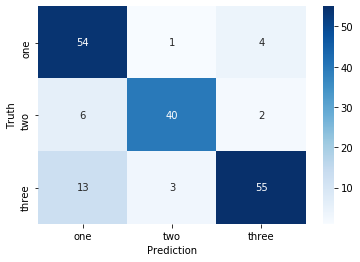

In [28]:
metrics, cm = cross_validate(KNeighborsClassifier, StratifiedKFold(9), X.iloc[:, :-1], y)

print_results(metrics, 'KNN-dropped')
plot_cm(cm, classes)

Ale wyrzucanie to nie jest chyba najlepsze rozwiązanie. Można zamiast tego zastosować któryś z rodzajów normalizacji.

In [43]:
from sklearn.preprocessing import Normalizer, StandardScaler

# NORMALIZACJA
X_normalized = X.copy()
# musimy zastosować transpozycję - ze względu na działanie Normalizer
normalized = Normalizer().fit_transform(X.T)
X_normalized[:] = normalized.T
X_normalized.head()

,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,0.081882,0.049518,0.076455,0.059122,0.094479,0.088238,0.101461,0.054861,0.101553,0.076013,0.079202,0.108582,0.098523
1,0.075956,0.051545,0.067330,0.042446,0.074393,0.083511,0.091514,0.050943,0.056763,0.059032,0.079964,0.094178,0.097135
2,0.075725,0.068341,0.084006,0.070491,0.075137,0.088238,0.107429,0.058780,0.124613,0.076552,0.078441,0.087807,0.109624
3,0.082688,0.056468,0.078657,0.063670,0.084064,0.121327,0.115719,0.047024,0.096675,0.105125,0.065494,0.095563,0.136914
4,0.076186,0.075001,0.090298,0.079587,0.087783,0.088238,0.089193,0.076414,0.080710,0.058223,0.079202,0.081159,0.067994


Results for KNN-normalized
----
  Accuracy:  0.9438202247191011
  Precision: 0.9450854700854702
  Recall:    0.9485524256651018
  F1 score:  0.9454722749314781
  Mislabeled 10 out of 178




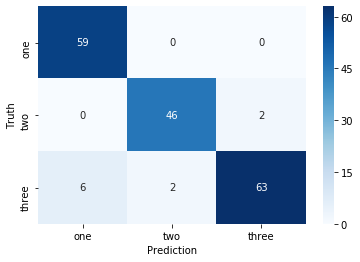

In [44]:
metrics, cm = cross_validate(KNeighborsClassifier, StratifiedKFold(9), X_normalized, y)

print_results(metrics, 'KNN-normalized')
plot_cm(cm, classes)

In [45]:
# STANDARYZACJA
X_standard = X.copy()
# nie ma konieczności transponowania
standard = StandardScaler().fit_transform(X)
X_standard[:] = standard
X_standard.head()

,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1.518613,-0.562250,0.232053,-1.169593,1.913905,0.808997,1.034819,-0.659563,1.224884,0.251717,0.362177,1.847920,1.013009
1,0.246290,-0.499413,-0.827996,-2.490847,0.018145,0.568648,0.733629,-0.820719,-0.544721,-0.293321,0.406051,1.113449,0.965242
2,0.196879,0.021231,1.109334,-0.268738,0.088358,0.808997,1.215533,-0.498407,2.135968,0.269020,0.318304,0.788587,1.395148
3,1.691550,-0.346811,0.487926,-0.809251,0.930918,2.491446,1.466525,-0.981875,1.032155,1.186068,-0.427544,1.184071,2.334574
4,0.295700,0.227694,1.840403,0.451946,1.281985,0.808997,0.663351,0.226796,0.401404,-0.319276,0.362177,0.449601,-0.037874


Results for KNN-standard
----
  Accuracy:  0.9662921348314607
  Precision: 0.9652904011869552
  Recall:    0.9695813771517997
  F1 score:  0.9669335052163787
  Mislabeled 6 out of 178




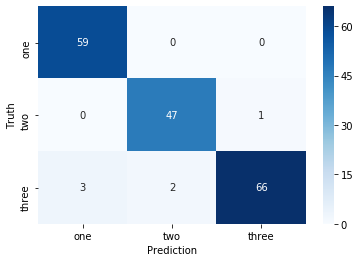

In [46]:
metrics, cm = cross_validate(KNeighborsClassifier, StratifiedKFold(9), X_standard, y)

print_results(metrics, 'KNN-standard')
plot_cm(cm, classes)

Jak widać najlepsze rezultaty uzyskujemy dla standaryzacji.

Ciekawostka: K-NN jest jednym z najlepszych klasyfikatorów dla zbioru Glass (który jest stosunkowo trudny)! Spróbujmy powtórzyć walidację krzyżową dla tego zbioru.

In [48]:
X, y, classes = prepare_dataset('glass')
X_standard = X.copy()
standard = StandardScaler().fit_transform(X)
X_standard[:] = standard
X_standard.head()

,refractive index,Sodium,Magnesium,Aluminum,Silicon,Potassium,Calcium,Barium,Iron
ID,,,,,,,,,
1,0.872868,0.284953,1.254639,-0.692442,-1.127082,-0.671705,-0.145766,-0.352877,-0.586451
2,-0.249333,0.591817,0.636168,-0.170460,0.102319,-0.026213,-0.793734,-0.352877,-0.586451
3,-0.721318,0.149933,0.601422,0.190912,0.438787,-0.164533,-0.828949,-0.352877,-0.586451
4,-0.232831,-0.242853,0.698710,-0.310994,-0.052974,0.112107,-0.519052,-0.352877,-0.586451
5,-0.312045,-0.169205,0.650066,-0.411375,0.555256,0.081369,-0.624699,-0.352877,-0.586451


Results for KNN-glass-standard
----
  Accuracy:  0.6495327102803738
  Precision: 0.6136850086340749
  Recall:    0.5566707255908708
  F1 score:  0.5718353570872137
  Mislabeled 75 out of 214




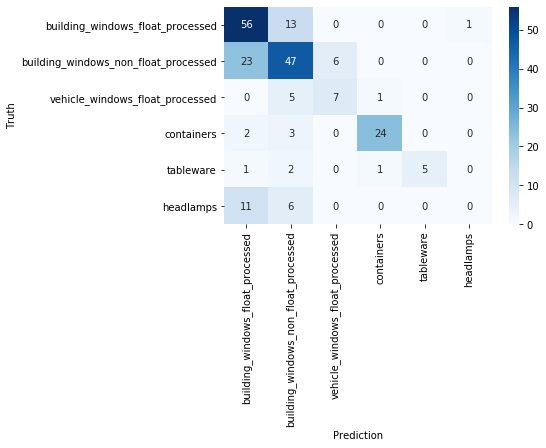

In [49]:
metrics, cm = cross_validate(KNeighborsClassifier, StratifiedKFold(9), X_standard, y)
print_results(metrics, 'KNN-glass-standard')
plot_cm(cm, classes)

ZADANIE: spróbuj dostroić klasyfikator KNN, regulując liczbę sąsiadów (`n_neighbors`) oraz miarę odległości (`metric`, zgodnie z dokumentacją: [metryki odległości](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.DistanceMetric.html).

In [47]:
knn = KNeighborsClassifier(n_neighbors=4)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
y_train_pred = knn.predict(X_train)

In [48]:
print_results(calculate_metrics(y_train, y_train_pred), classifier_id='knn-wine-4-train')
print_results(calculate_metrics(y_test, y_pred), classifier_id='knn-wine-4')

Results for knn-wine-4-train
----
  Accuracy:  0.9398496240601504
  Precision: 0.9380729977512541
  Recall:    0.949685534591195
  F1 score:  0.9401550830122258
  Mislabeled 8 out of 133


Results for knn-wine-4
----
  Accuracy:  1.0
  Precision: 1.0
  Recall:    1.0
  F1 score:  1.0
  Mislabeled 0 out of 45




### Kroswalidacja

Results for KNN + CV
----
  Accuracy:  0.9719101123595506
  Precision: 0.9705376344086022
  Recall:    0.9765258215962441
  F1 score:  0.9727673659799928
  Mislabeled 5 out of 178




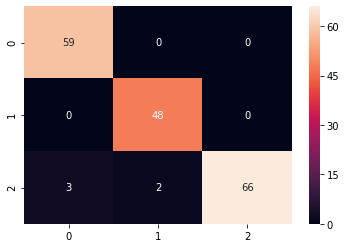

In [30]:
from sklearn.model_selection import KFold, StratifiedKFold

cross_val = KFold(n_splits=5, shuffle=True)

predicted = []
target = []

for train_index, test_index in cross_val.split(X):
    knn = KNeighborsClassifier()
    X_train_cv, X_test_cv = X.iloc[train_index], X.iloc[test_index]
    y_train_cv, y_test_cv = y.iloc[train_index], y.iloc[test_index]
    knn.fit(X_train_cv, y_train_cv)
    predicted = np.concatenate((predicted, knn.predict(X_test_cv)))
    target = np.concatenate((target, y_test_cv))

print_results(calculate_metrics(target, predicted), 'KNN + CV')
cm_knn = confusion_matrix(target, predicted)

sns.heatmap(cm_knn, annot=True)

In [51]:
def cross_validate(classifier, kfold, X, y, params=None, talk=True):
    if params is None:
        params = {}
    predicted = []
    target = []

    for train_index, test_index in kfold.split(X, y):
        clf = classifier(**params)
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        clf.fit(X=X_train, y=y_train)
        predicted = np.concatenate((predicted, clf.predict(X_test)))
        target = np.concatenate((target, y_test))
    
    metrics = calculate_metrics(target, predicted)
    cm = confusion_matrix(target, predicted)
    if talk:
        print_results(metrics, clf.__class__.__name__)
        sns.heatmap(cm, annot=True)
        plt.show()
    else:
        return metrics, cm

Results for KNeighborsClassifier
----
  Accuracy:  0.9550561797752809
  Precision: 0.9524244268614325
  Recall:    0.9624413145539906
  F1 score:  0.9553333895126283
  Mislabeled 8 out of 178




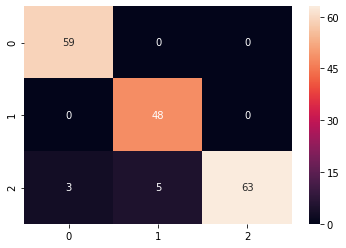

In [52]:
cross_validate(KNeighborsClassifier, StratifiedKFold(10), X, y)

Testy parametrów

In [71]:
def plot_results(result_df, title, plot_type='bar'):
    ind = np.arange(len(result_df))
    fig, ax = plt.subplots(figsize=(20, 10))
    width = 1 / len(result_df.columns)
    if plot_type == 'bar':
        plot = lambda index, data, label: ax.bar(index, data, width=width, label=label)
    elif plot_type == 'plot':
        plot = lambda index, data, label: ax.plot(index, data, label=label)
    plot(ind, result_df['accuracy'], 'Accuracy')
    plot(ind+width, result_df['precision'], 'Precision')
    plot(ind+2*width, result_df['recall'], 'Recall')
    plot(ind+3*width, result_df['fscore'], 'fscore')
    
    ax.set_title(title)
    ax.set_ylabel('Scores')
    ax.set_xlabel(result_df.index.name)
    ax.set_xticks(ind + 3 * width / 2)
    ax.set_xticklabels(result_df.index)
    ax.autoscale()
    ax.legend()
    return ax

def test_params(X, y, classifier, classifier_param, classifier_const_params=None,
                kfold=None,
                normalizer=None):
    X = X.copy()
    if classifier_const_params is None:
        classifier_const_params = {}
    if kfold is None:
        kfold = StratifiedKFold(10)
    if normalizer is not None:
        normalizer.fit(X)
        X_preprocessed = normalizer.transform(X.values)
        X[:] = X_preprocessed
    param = list(classifier_param.keys())[0]
    data = {param: [],
            'accuracy': [],
            'precision': [],
            'recall': [],
            'fscore': [],
            'cm': []}
    for index, value in enumerate(list(classifier_param.values())[0]):
        kwargs = {param: value}
        clf = classifier
        (accuracy,
         precision,
         recall,
         fscore,
         mislabeled,
         total), cm = cross_validate(clf,
                                     kfold,
                                     X, y,
                                     talk=False, params={**kwargs, **classifier_const_params})
        data[param].append(value)
        data['accuracy'].append(accuracy)
        data['precision'].append(precision)
        data['recall'].append(recall)
        data['fscore'].append(fscore)
        data['cm'].append(cm)
    
    df = pd.DataFrame(data).set_index(param)
    return plot_results(df, f'{clf.__class__.__name__} - {param}', plot_type='plot'), df

/Users/piotrz/.miniconda3/envs/ds-training/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 9 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/Users/piotrz/.miniconda3/envs/ds-training/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 9 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/Users/piotrz/.miniconda3/envs/ds-training/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 9 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/Users/piotrz/.miniconda3/envs/ds-training/lib/python3.7/site-packages/sklearn/

,accuracy,precision,recall,fscore,cm
metric,,,,,
euclidean,0.686916,0.680390,0.623839,0.633825,"[[58, 11, 0, 0, 0, 1], [19, 49, 5, 0, 1, 2], [..."
manhattan,0.691589,0.680067,0.631918,0.639664,"[[59, 10, 0, 0, 0, 1], [18, 49, 5, 0, 2, 2], [..."
chebyshev,0.640187,0.663707,0.551557,0.577184,"[[58, 11, 0, 0, 0, 1], [26, 42, 4, 1, 0, 3], [..."
minkowski,0.686916,0.680390,0.623839,0.633825,"[[58, 11, 0, 0, 0, 1], [19, 49, 5, 0, 1, 2], [..."


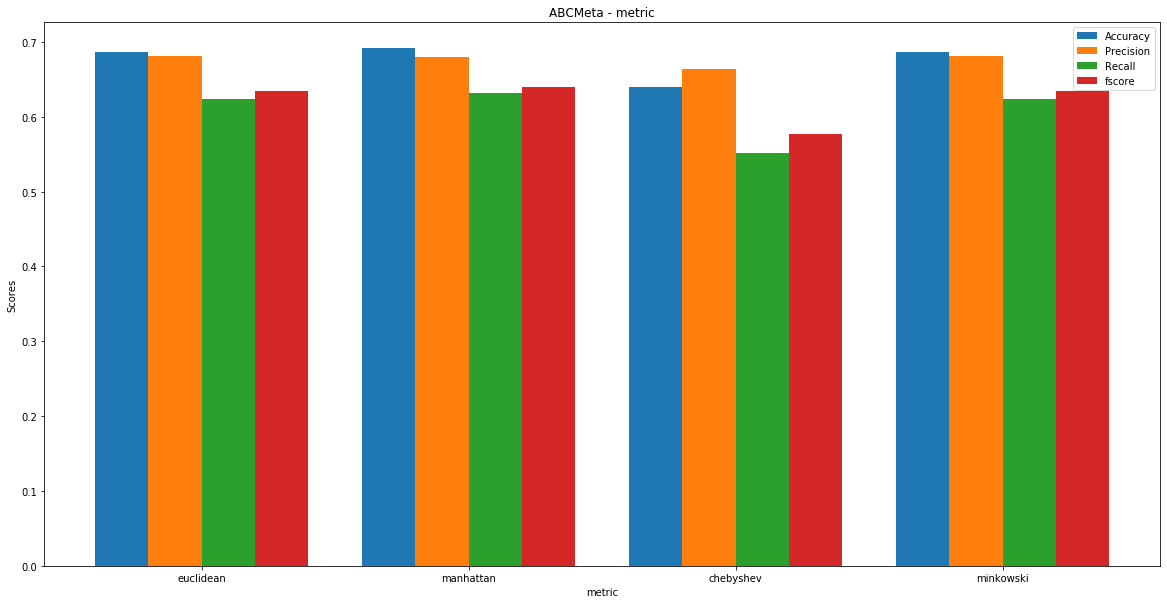

In [70]:
ax, results = test_params(X, y, KNeighborsClassifier, {'metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski']},
                         {'n_neighbors': 3})
results

/Users/piotrz/.miniconda3/envs/ds-training/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 9 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/Users/piotrz/.miniconda3/envs/ds-training/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 9 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/Users/piotrz/.miniconda3/envs/ds-training/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 9 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/Users/piotrz/.miniconda3/envs/ds-training/lib/python3.7/site-packages/sklearn/

,accuracy,precision,recall,fscore,cm
n_neighbors,,,,,
1,0.663551,0.656900,0.655149,0.653614,"[[53, 11, 0, 0, 0, 6], [17, 45, 5, 1, 1, 7], [..."
2,0.696262,0.705091,0.602400,0.623332,"[[64, 5, 0, 0, 0, 1], [23, 47, 4, 0, 1, 1], [1..."
3,0.686916,0.680390,0.623839,0.633825,"[[58, 11, 0, 0, 0, 1], [19, 49, 5, 0, 1, 2], [..."
4,0.663551,0.703489,0.575481,0.598946,"[[59, 10, 0, 0, 0, 1], [23, 46, 6, 0, 1, 0], [..."
5,0.658879,0.591062,0.557691,0.566903,"[[57, 12, 0, 0, 0, 1], [20, 49, 6, 0, 1, 0], [..."
6,0.654206,0.567255,0.545058,0.550732,"[[58, 11, 0, 0, 0, 1], [22, 48, 4, 0, 2, 0], [..."
7,0.640187,0.725641,0.561664,0.570212,"[[54, 16, 0, 0, 0, 0], [22, 47, 4, 0, 3, 0], [..."
8,0.640187,0.559711,0.541845,0.545579,"[[57, 12, 0, 0, 0, 1], [24, 45, 4, 0, 3, 0], [..."
9,0.630841,0.555262,0.540449,0.543572,"[[54, 15, 0, 0, 0, 1], [24, 45, 4, 0, 3, 0], [..."


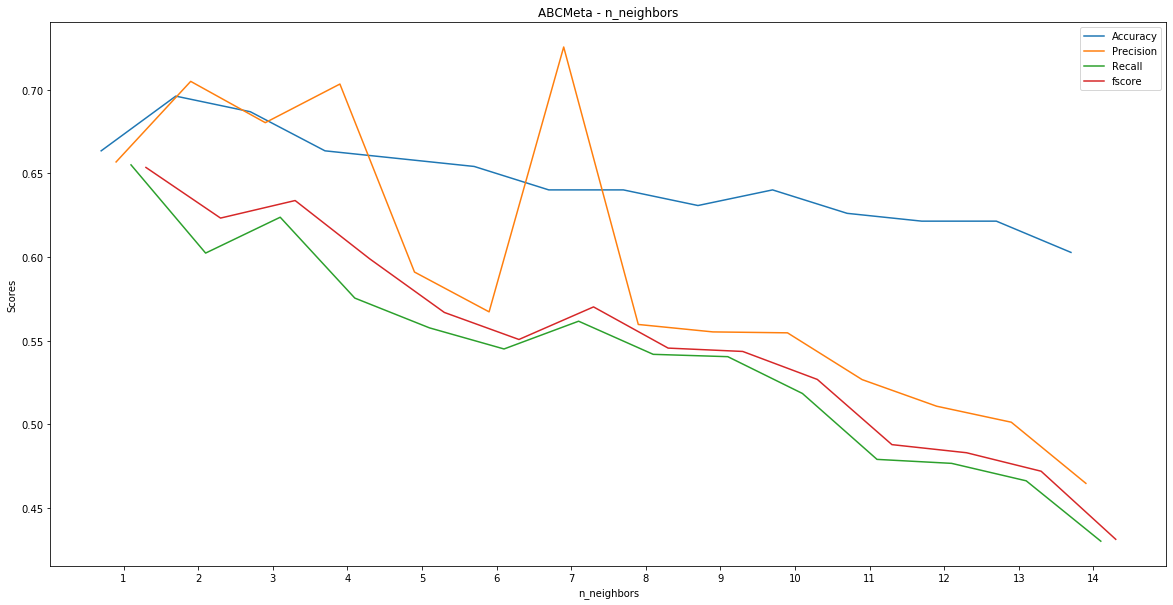

In [74]:
ax, results = test_params(X, y, KNeighborsClassifier, {'n_neighbors': range(1,15)},)
results

In [36]:
def test_classifiers(X, y, classifiers,
                     kfold=None,
                     normalizer=None):
    X = X.copy()
    if kfold is None:
        kfold = StratifiedKFold(10)
    if normalizer is not None:
        normalizer.fit(X)
        X_preprocessed = normalizer.transform(X.values)
        X[:] = X_preprocessed
    data = {'classifier': [],
            'accuracy': [],
            'precision': [],
            'recall': [],
            'fscore': [],
            'cm': []}
    for index, classifier in enumerate(classifiers):
        name =  f"{classifier.__class__.__name__}-{index}"
        (accuracy,
         precision,
         recall,
         fscore,
         mislabeled,
         total), cm = cross_validate(classifier,
                                     kfold,
                                     X, y,
                                     talk=False)
        data['classifier'].append(name)
        data['accuracy'].append(accuracy)
        data['precision'].append(precision)
        data['recall'].append(recall)
        data['fscore'].append(fscore)
        data['cm'].append(cm)
    
    df = pd.DataFrame(data).set_index('classifier')
    return plot_results(df, 'Classifiers comparison'), df

(<matplotlib.axes._subplots.AxesSubplot at 0x1a20522ba8>,
                         accuracy  precision    recall    fscore  \
 classifier                                                        
 KNeighborsClassifier-0  0.955056   0.954350  0.962441  0.956448   
 KNeighborsClassifier-1  0.966292   0.965503  0.971831  0.967562   
 
                                                           cm  
 classifier                                                    
 KNeighborsClassifier-0  [[59, 0, 0], [0, 48, 0], [5, 3, 63]]  
 KNeighborsClassifier-1  [[59, 0, 0], [0, 48, 0], [4, 2, 65]]  )

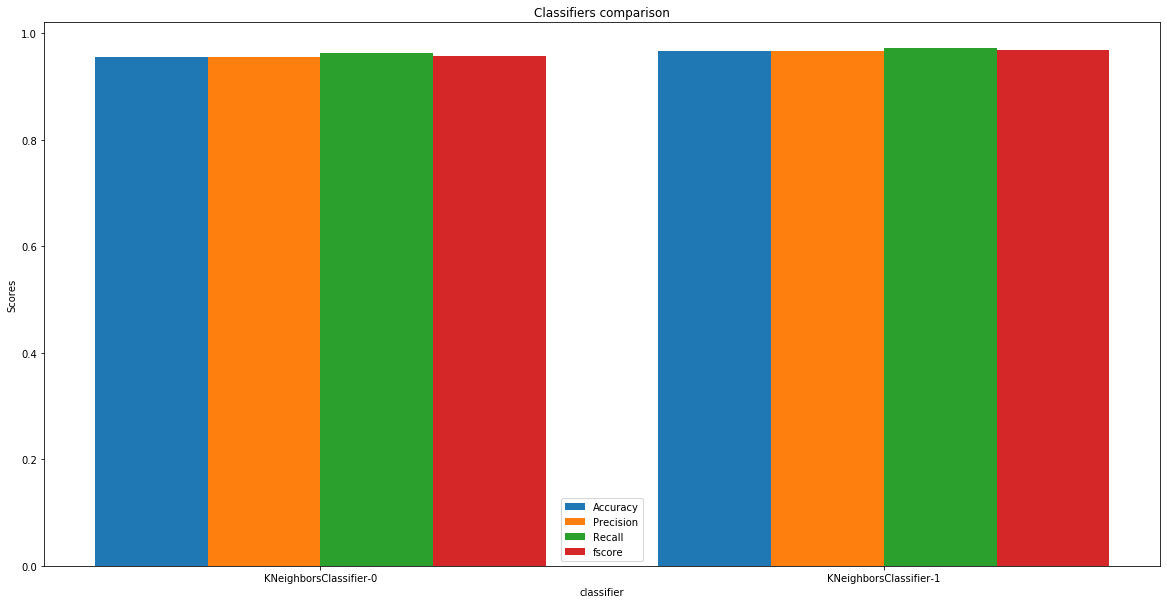

In [37]:
test_classifiers(X, y, [KNeighborsClassifier(n_neighbors=3), KNeighborsClassifier(n_neighbors=10)])

In [38]:
def test_folds(X, y, classifier, folds, kfold=None,
               normalizer=None):
    X = X.copy()
    if kfold is None:
        kfold = StratifiedKFold
    if normalizer is not None:
        normalizer.fit(X)
        X_preprocessed = normalizer.transform(X.values)
        X[:] = X_preprocessed
    data = {'folds': folds,
            'accuracy': [],
            'precision': [],
            'recall': [],
            'fscore': [],
            'cm': []}
    for n in folds:
        (accuracy,
         precision,
         recall,
         fscore,
         mislabeled,
         total), cm = cross_validate(classifier,
                                     kfold(n),
                                     X, y,
                                     talk=False)
        data['accuracy'].append(accuracy)
        data['precision'].append(precision)
        data['recall'].append(recall)
        data['fscore'].append(fscore)
        data['cm'].append(cm)
    
    df = pd.DataFrame(data).set_index('folds')
    return plot_results(df, 'Number of folds', plot_type='plot'), df

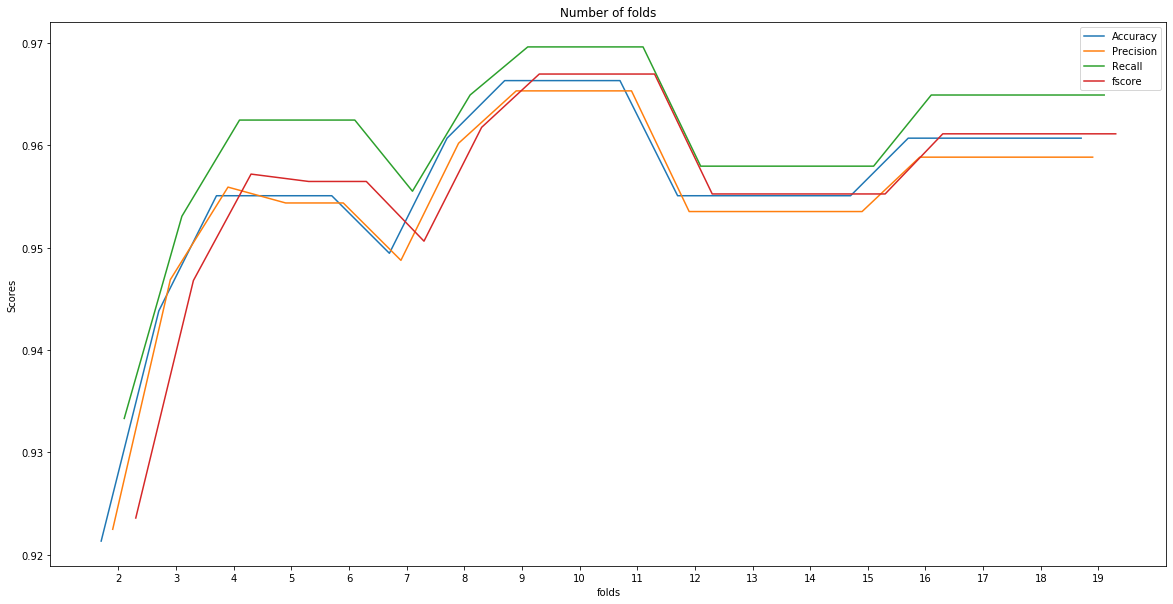

,accuracy,precision,recall,fscore,cm
folds,,,,,
2,0.921348,0.922500,0.933317,0.923601,"[[58, 0, 1], [0, 48, 0], [8, 5, 58]]"
3,0.943820,0.946866,0.953052,0.946781,"[[59, 0, 0], [0, 48, 0], [8, 2, 61]]"
4,0.955056,0.955897,0.962441,0.957168,"[[59, 0, 0], [0, 48, 0], [6, 2, 63]]"
5,0.955056,0.954350,0.962441,0.956448,"[[59, 0, 0], [0, 48, 0], [5, 3, 63]]"
6,0.955056,0.954350,0.962441,0.956448,"[[59, 0, 0], [0, 48, 0], [5, 3, 63]]"
7,0.949438,0.948750,0.955497,0.950622,"[[59, 0, 0], [0, 47, 1], [5, 3, 63]]"
8,0.960674,0.960180,0.964887,0.961730,"[[59, 0, 0], [0, 47, 1], [4, 2, 65]]"
9,0.966292,0.965290,0.969581,0.966934,"[[59, 0, 0], [0, 47, 1], [3, 2, 66]]"
10,0.966292,0.965290,0.969581,0.966934,"[[59, 0, 0], [0, 47, 1], [3, 2, 66]]"


In [39]:
ax, df = test_folds(X, y, KNeighborsClassifier, range(2,20,1), kfold=StratifiedKFold)
plt.show()
df

In [40]:
def test_cross_val(X, y, classifier, kfolds,
               normalizer=None):
    X = X.copy()
    if normalizer is not None:
        normalizer.fit(X)
        X_preprocessed = normalizer.transform(X.values)
        X[:] = X_preprocessed
    data = {'cross_val': [],
            'accuracy': [],
            'precision': [],
            'recall': [],
            'fscore': [],
            'cm': []}
    for index, kfold in enumerate(kfolds):
        name = f'{kfold.__class__.__name__}-{kfold.n_splits}_{index}'
        (accuracy,
         precision,
         recall,
         fscore,
         mislabeled,
         total), cm = cross_validate(classifier,
                                     kfold,
                                     X, y,
                                     talk=False)
        data['cross_val'].append(name)
        data['accuracy'].append(accuracy)
        data['precision'].append(precision)
        data['recall'].append(recall)
        data['fscore'].append(fscore)
        data['cm'].append(cm)
    
    df = pd.DataFrame(data).set_index('cross_val')
    return plot_results(df, 'Cross-validation method'), df

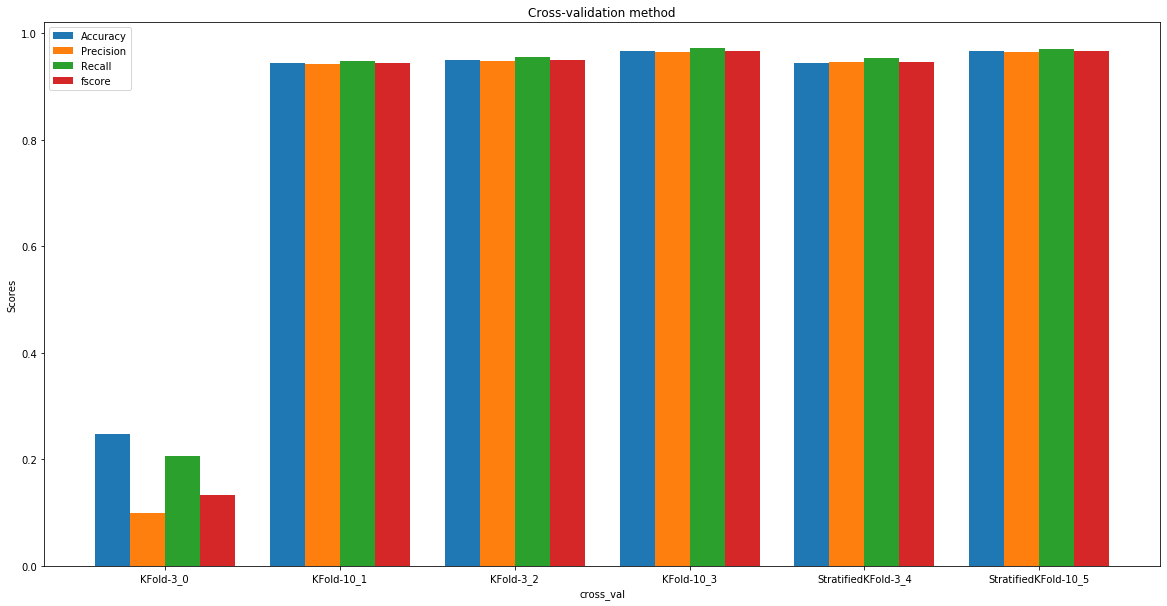

,accuracy,precision,recall,fscore,cm
cross_val,,,,,
KFold-3_0,0.247191,0.099099,0.206573,0.133942,"[[0, 0, 59], [3, 0, 45], [17, 10, 44]]"
KFold-10_1,0.943820,0.941913,0.948552,0.944153,"[[59, 0, 0], [0, 46, 2], [4, 4, 63]]"
KFold-3_2,0.949438,0.948750,0.955497,0.950622,"[[59, 0, 0], [0, 47, 1], [5, 3, 63]]"
KFold-10_3,0.966292,0.965503,0.971831,0.967562,"[[59, 0, 0], [0, 48, 0], [4, 2, 65]]"
StratifiedKFold-3_4,0.943820,0.946866,0.953052,0.946781,"[[59, 0, 0], [0, 48, 0], [8, 2, 61]]"
StratifiedKFold-10_5,0.966292,0.965290,0.969581,0.966934,"[[59, 0, 0], [0, 47, 1], [3, 2, 66]]"


In [41]:
ax, df = test_cross_val(X, y, KNeighborsClassifier(), [KFold(3, False), KFold(10, False), KFold(3, True), KFold(10, True), StratifiedKFold(3), StratifiedKFold(10)])
plt.show()
df

In [42]:
def test_normalization(X, y, classifier, normalizers,
                       kfold=None):
    X = X.copy()
    if kfold is None:
        kfold = StratifiedKFold(10)
    data = {'normalizer': [],
            'accuracy': [],
            'precision': [],
            'recall': [],
            'fscore': [],
            'cm': []}
    for index, normalizer in enumerate(normalizers):
        name = f'{normalizer.__class__.__name__}_{index}'
        normalizer.fit(X)
        X_preprocessed = normalizer.transform(X.values)
        X_new = X.copy()
        X_new[:] = X_preprocessed
        (accuracy,
         precision,
         recall,
         fscore,
         mislabeled,
         total), cm = cross_validate(classifier,
                                     kfold,
                                     X_new, y,
                                     talk=False)
        data['normalizer'].append(name)
        data['accuracy'].append(accuracy)
        data['precision'].append(precision)
        data['recall'].append(recall)
        data['fscore'].append(fscore)
        data['cm'].append(cm)
    
    df = pd.DataFrame(data).set_index('normalizer')
    return plot_results(df, 'Normalization method'), df

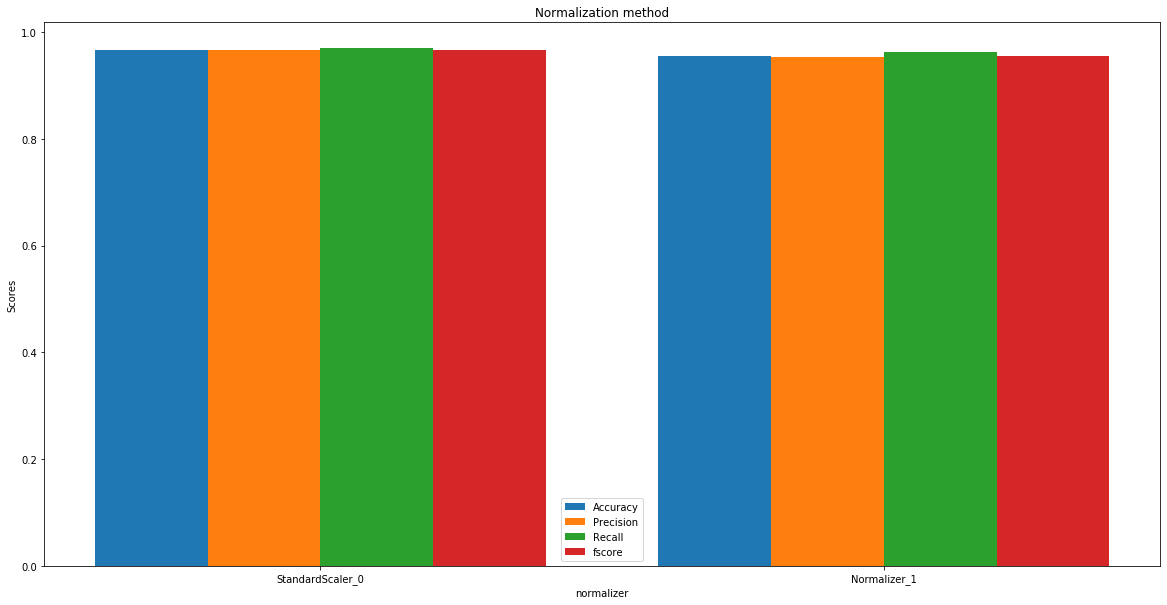

,accuracy,precision,recall,fscore,cm
normalizer,,,,,
StandardScaler_0,0.966292,0.965290,0.969581,0.966934,"[[59, 0, 0], [0, 47, 1], [3, 2, 66]]"
Normalizer_1,0.955056,0.952424,0.962441,0.955333,"[[59, 0, 0], [0, 48, 0], [3, 5, 63]]"


In [43]:
ax, df = test_normalization(X, y, KNeighborsClassifier(), [standardizer, normalizer])
plt.show()
df